In [ ]:
# 참고 : https://www.kaggle.com/kmader/finding-lungs-in-ct-data

In [1]:
# 내 구글 드라이버에 연동
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# 1.먼저 본인의 Kaggle 계정에서 API Token 을 다운받습니다.(kaggle.json)
# 2.Kaggle API를 설치합니다.
!pip install kaggle   
# 3.kaggle.json 파일을 VM에 업로드 합니다.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"briansong7272","key":"05bcb4a34f899140cce615a6c3c7d225"}'}

In [7]:
# 4.파일이 재대로 업로드 됐는지 확인
!ls -1ha kaggle.json

kaggle.json


In [8]:
# 5.Kaggle API 가 Token을 사용하게 하기 위해 kaggle.json 파일을 ~/.kaggle로 이동 시킵니다.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# 6. Permission Warning 이 일어나지 않도록 권한 부여
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
# 7.Kaggle 에서 chest-xray dataset을 다운 받기 위해 API Command 를 복사해서 가져옵니다.
# dataset URL : https://www.kaggle.com/kmader/finding-lungs-in-ct-data

!kaggle datasets download -d kmader/finding-lungs-in-ct-data

 99% 1.02G/1.03G [00:18<00:00, 73.1MB/s]
100% 1.03G/1.03G [00:18<00:00, 58.7MB/s]


In [11]:
# 압축파일 해제
from zipfile import ZipFile

with ZipFile('finding-lungs-in-ct-data.zip') as z: 
    z.extractall()

In [59]:
# preprocess

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize

import os, glob

In [60]:
img_list = sorted(glob.glob('2d_images/*.tif'))   # CT 이미지 리스트
mask_list = sorted(glob.glob('2d_masks/*.tif'))   # Mask 이미지 리스트

print(len(img_list), len(mask_list))

267 267


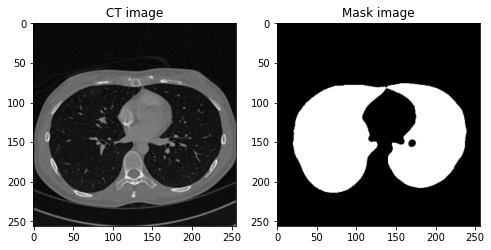

In [61]:
IMG_SIZE = 256

x_data, y_data = np.empty((2, len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

for i, img_path in enumerate(img_list):
    img = imread(img_path)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    x_data[i] = img
    
for i, img_path in enumerate(mask_list):
    img = imread(img_path)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    y_data[i] = img
    
y_data /= 255.

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].set_title("CT image")
ax[0].imshow(x_data[12].squeeze(), cmap='gray')
ax[1].set_title("Mask image")
ax[1].imshow(y_data[12].squeeze(), cmap='gray')

In [62]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


In [63]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

In [64]:
inputs = Input(shape=(256, 256, 1))

net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 128)      

In [65]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
])

Epoch 1/100
8/8 [==============================] - 2s 194ms/step - loss: 0.5978 - acc: 0.7063 - mse: 0.1961 - val_loss: 0.5239 - val_acc: 0.7712 - val_mse: 0.1681
Epoch 2/100
8/8 [==============================] - 1s 172ms/step - loss: 0.5292 - acc: 0.7449 - mse: 0.1730 - val_loss: 0.4864 - val_acc: 0.7716 - val_mse: 0.1551
Epoch 3/100
8/8 [==============================] - 1s 170ms/step - loss: 0.4963 - acc: 0.7462 - mse: 0.1616 - val_loss: 0.4480 - val_acc: 0.7751 - val_mse: 0.1450
Epoch 4/100
8/8 [==============================] - 1s 172ms/step - loss: 0.4686 - acc: 0.7485 - mse: 0.1545 - val_loss: 0.4277 - val_acc: 0.7751 - val_mse: 0.1378
Epoch 5/100
8/8 [==============================] - 1s 174ms/step - loss: 0.4466 - acc: 0.7485 - mse: 0.1466 - val_loss: 0.4138 - val_acc: 0.7751 - val_mse: 0.1365
Epoch 6/100
8/8 [==============================] - 1s 172ms/step - loss: 0.4487 - acc: 0.7342 - mse: 0.1491 - val_loss: 0.4392 - val_acc: 0.7751 - val_mse: 0.1428
Epoch 7/100
8/8 [=====

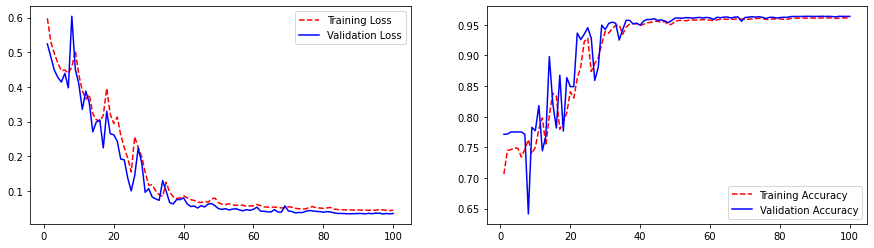

In [66]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = history.history['loss'] 
validation_loss = history.history['val_loss']

training_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

In [67]:
model.save("/content/gdrive/My Drive/CV/CT_lung_segmentation/CT_lung_seg.h5")

In [68]:
preds = model.predict(x_val)

fig, ax = plt.subplots(len(x_val), 3, figsize=(12, 120))

for i, pred in enumerate(preds):
    ax[i, 0].set_title("CT image")
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].set_title("Mask image")
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].set_title("Predict image")
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')

Output hidden; open in https://colab.research.google.com to view.